In [1]:
from typing import Callable, List, Tuple
from pathlib import Path
import os
from argparse import Namespace
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange

import torch
from torch import nn

import albumentations as albu
import catalyst
from catalyst.dl import SupervisedRunner

# models
import segmentation_models_pytorch as smp
import catalyst.contrib.models.cv.segmentation as cataseg

# optimizer
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

# losses
from catalyst.contrib.nn import DiceLoss, IoULoss
from torch.nn import MSELoss

# metrics
from catalyst.dl import IouCallback, CriterionCallback, MetricAggregationCallback, DiceCallback, EarlyStoppingCallback
from catalyst.dl import SupervisedRunner 

# utilities
from pytorch_toolbelt.utils import count_parameters
import utils as u
from _torch.catalyst import SegmentationDataset, get_loaders, DataLoader, I2IDataset, get_tensorboard_log

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

SEED = 42
catalyst.utils.set_global_seed(SEED)
catalyst.utils.prepare_cudnn(deterministic=True)

torch: 1.7.0, catalyst: 20.11


In [2]:
def _inv(x, **params):
        return -x
    
def _abs(x, **params):
    return np.abs(x)

def _env(x, **params):
    return u.envelope(x)

def pre_transform(target_size, abs=False, env=False):
    t = [albu.Resize(target_size[0], target_size[1], p=1)]
    if abs:
        t.append(albu.Lambda(image=_abs, name='amplitude', p=1))
    if env:
        t.append(albu.Lambda(image=_env, name='envelope', p=1))

    return t

def aug_transform():
    return [
        albu.HorizontalFlip(p=0.5),
        # albu.Downscale(scale_min=0.5, scale_max=0.95, p=0.1),
    ]  
  
def tensor_transforms(v2=False):
    # we convert it to torch.Tensor
    return [albu.pytorch.ToTensorV2()] if v2 else [albu.pytorch.ToTensor()]

def phase_transforms(p=.1):
    return [albu.Lambda(image=_inv, name='inversion', p=p)]

def compose(transforms_list):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_list for item in sublist
    ])
    return result

In [3]:
def concat_ch(x, y):
    return np.concatenate((x,y), axis=-1)

## Arguments

In [4]:
args = Namespace()
args.gpus = (0,)
args.num_workers = 4
args.is_fp16_used = False

args.batch_size = 16

args.epochs = 100
args.stopping_patience = 20
args.lr = 0.01
args.lr_enc = 0.005
args.lr_plateau_factor=0.25
args.lr_plateau_patience=10
args.opt_weight_decay=0.0003
args.enc_weight_decay=0.00003

args.num_classes = 1
args.patch_shape = (256, 256)
args.target_shape = (256, 256)
args.patch_stride = (16, 16)

args.loss_dice = 0.
args.loss_iou = 0.
args.loss_bce = 0.
args.loss_mse = 0.
args.loss_lov = 1.
args.normalize = True
args.phase_inversion_training = .5

args.include_eni1 = False

# https://pypi.org/project/segmentation-models-pytorch/#encoders
args.backbone = "resnext50_32x4d" #"efficientnet-b3"
args.activation = None  # will be Identity, can be "sigmoid", "softmax2d" or Callable (like nn.Tanh)
args.pretrained = True
args.use_fpn = False
attempt = 0
args.outname = "tgs_%s_%s%s_%dto%d_attempt%d" % \
                   ("FPN" if args.use_fpn else "UNET", args.backbone, "_pre" if args.pretrained else "",
                    args.patch_shape[0], args.target_shape[0], attempt)
args.logdir = Path("./results/eni_salt/") / args.outname

In [5]:
args.logdir

PosixPath('results/eni_salt/tgs_UNET_resnext50_32x4d_pre_256to256_attempt0')

In [6]:
batch_size = args.batch_size * (2 if args.is_fp16_used else 1)

print(f"batch_size: {batch_size}")

batch_size: 16


In [7]:
device = catalyst.utils.get_device()
print(f"device: {device}")

device: cuda


In [8]:
u.save_args_to_file(args.logdir, args)

In [9]:
save_opts = {'format':'png', 'dpi':150, 'bbox_inches':'tight'}

## Dataset

### Load TGS

In [10]:
from glob import glob
from PIL import Image

In [11]:
def _is_valid_file(filename, extensions):
    return any([filename.lower().endswith(ext) for ext in extensions])

In [12]:
tgs_root = "/nas/public/dataset/geophysics/tgs-salt-id-challenge/"

In [13]:
image_root, _, image_names = sorted(os.walk(os.path.join(tgs_root, 'images'), followlinks=True))[0]
mask_root, _, mask_names = sorted(os.walk(os.path.join(tgs_root, 'masks'), followlinks=True))[0]

smallest_list = image_names if len(image_names) <= len(mask_names) else mask_names
biggest_list = image_names if smallest_list == mask_names else mask_names

samples = []

for element in smallest_list:
    if element in biggest_list and _is_valid_file(element, ['.mat', '.png', '.npy']):
        samples.append((os.path.join(image_root, element), os.path.join(mask_root, element)))

In [14]:
t = compose([pre_transform(args.target_shape)])

tgs_patches_images = []
tgs_patches_masks = []

for (img_path, msk_path) in samples:
    img = u.normalize_01_11(u.png2float(np.asarray(Image.open(img_path)).mean(axis=-1)))
    msk = u.binary_mask(np.asarray(Image.open(msk_path)).copy())
    tran = t(image=img, mask=msk)
    img, msk = tran['image'], tran['mask']
    tgs_patches_images.append(img)
    tgs_patches_masks.append(msk)

In [15]:
tgs_patches_images = np.expand_dims(np.asarray(tgs_patches_images), -1)
tgs_patches_masks = np.expand_dims(np.asarray(tgs_patches_masks), -1)
print(tgs_patches_images.shape)
print(tgs_patches_masks.shape)

(4000, 256, 256, 1)
(4000, 256, 256, 1)


In [16]:
tgs_patches_images.min(), tgs_patches_images.max()

(-1.0, 1.0)

In [17]:
tgs_patches_masks.min(), tgs_patches_masks.max()

(0, 1)

### ENI

In [18]:
ROOT = Path("/nas/home/fpicetti/datasets/salt_eni")

In [19]:
images_train = np.load(ROOT / "image1.npy")
images_test  = np.load(ROOT / "image2.npy")
if args.normalize:
    images_train, min_, max_ = u.normalize(images_train)
    images_test  = u.normalize_only(images_test)

masks_train = np.load(ROOT / "label1.npy")
masks_test  = np.load(ROOT / "label2.npy")

In [20]:
# cut the water in order to obtain 512 samples
z0 = images_train.shape[0] - 512

images_train = images_train[z0:]
images_test = images_test[z0:]
masks_train = masks_train[z0:]
masks_test = masks_test[z0:]

In [21]:
pe = u.PatchExtractor(args.patch_shape, stride=args.patch_stride)
print('total_patches: %d' % u.patch_extractor.count_patches(images_train.shape, pe.dim, pe.stride))
images_train.shape, u.patch_extractor.in_content_cropped_shape(images_train.shape, pe.dim, pe.stride)

total_patches: 2958


((512, 3026), (512, 3024))

In [22]:
eni_patches_images_train = pe.extract(images_train).reshape((-1,)+pe.dim+(1,))
eni_patches_images_test = pe.extract(images_test).reshape((-1,)+pe.dim+(1,))
eni_patches_masks_train = pe.extract(masks_train).reshape((-1,)+pe.dim+(1,))
eni_patches_masks_test = pe.extract(masks_test).reshape((-1,)+pe.dim+(1,))

print(eni_patches_images_train.shape)
print(eni_patches_masks_train.shape)
print(eni_patches_images_test.shape)
print(eni_patches_masks_test.shape)

(2958, 256, 256, 1)
(2958, 256, 256, 1)
(3009, 256, 256, 1)
(3009, 256, 256, 1)


In [23]:
if args.include_eni1:
    patches_images_train = np.concatenate((eni_patches_images_train, tgs_patches_images), axis=0)
    patches_masks_train = np.concatenate((eni_patches_masks_train, tgs_patches_masks), axis=0)
else:
    patches_images_train = tgs_patches_images
    patches_masks_train = tgs_patches_masks
    
print(patches_images_train.shape)
print(patches_masks_train.shape)

(4000, 256, 256, 1)
(4000, 256, 256, 1)


### Now define the data loader

In [24]:
train_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

valid_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

show_transforms  = compose([aug_transform()])

In [25]:
loaders = get_loaders(
    images=patches_images_train,
    masks=patches_masks_train.astype(np.float32),
    dataset = SegmentationDataset,
    random_state=SEED,
    valid_size=.1,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
    num_workers=args.num_workers,
    split_shuffle=True,
    epoch_shuffle=True,
)

## Model

In [26]:
# We will use Feature Pyramid Network with pre-trained backbone
# https://pypi.org/project/segmentation-models-pytorch/
if args.use_fpn:
    model = smp.FPN(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights='imagenet' if args.pretrained else None,
        decoder_pyramid_channels=256,
        decoder_segmentation_channels=128,
        decoder_dropout=0.3,
        decoder_merge_policy='add',
        activation=args.activation,
    )
else:
    model = smp.Unet(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights='imagenet' if args.pretrained else None,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type=None,
        activation=args.activation,
    )

In [27]:
count_parameters(model)

{'total': 31986705,
 'trainable': 31986705,
 'encoder': 22973632,
 'decoder': 9012928}

Check the initial guess

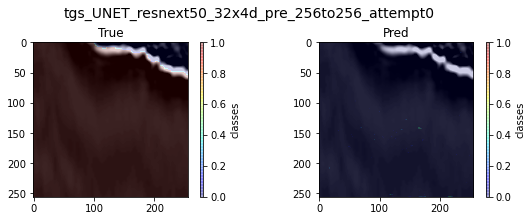

In [28]:
idx = 2
d = loaders['train'].dataset[idx]
img = d['image']
msk_true = d['mask'].unsqueeze(0)
msk_pred = model(img.unsqueeze(0))

img_ = img.detach().numpy().squeeze()
msk_true_ = msk_true.detach().numpy().squeeze()
msk_pred_ = msk_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(8,3))
plt.subplot(121), plt.title('True')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.imshow(msk_true_, cmap='jet', clim=(0,1), alpha=.2), plt.colorbar(label='classes', aspect=50)
plt.subplot(122), plt.title('Pred')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.imshow(msk_pred_, cmap='jet', clim=(0,1), alpha=.2), plt.colorbar(label='classes', aspect=50)

plt.suptitle(args.outname, fontsize=14)
plt.tight_layout(pad=.5)
plt.savefig(args.logdir/f"{idx}-th train patch with initialization.{save_opts['format']}", **save_opts)
plt.show()

#### Losses and metrics

In [29]:
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss(),
    "lov": catalyst.contrib.nn.LovaszLossBinary(),
}
callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_lov",
        criterion_key="lov"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": args.loss_dice,
                 "loss_iou": args.loss_iou,
                 "loss_bce": args.loss_bce,
                 "loss_lov": args.loss_lov},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # catalyst.callbacks.F1ScoreCallback(input_key="mask"),
    
    # stop training
    EarlyStoppingCallback(patience=args.stopping_patience, metric="loss", minimize=True,)
]

#### Optimizer and scheduling

In [30]:
# Since we use a pre-trained encoder, we will reduce the learning rate on it.
# This function removes weight_decay for biases and applies our layerwise_params
model_params = catalyst.utils.process_model_params(
    model, layerwise_params={"encoder*": dict(lr=args.lr_enc, weight_decay=args.enc_weight_decay)})

# Catalyst has new SOTA optimizers out of box
optimizer = Lookahead(RAdam(model_params, lr=args.lr, weight_decay=args.opt_weight_decay))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor=args.lr_plateau_factor,
                                                 patience=args.lr_plateau_patience)

## Train

In [31]:
# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [35]:
!rm -rf {args.logdir/"*log*"}
!rm -rf {args.logdir/"checkpoints"}

In [36]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=args.logdir,
    num_epochs=args.epochs,
    main_metric="iou",
    minimize_metric=False,
    fp16=dict(opt_level="O1") if args.is_fp16_used else None,
    verbose=True,
)

1/100 * Epoch (train):   0% 1/225 [00:20<1:15:00, 20.09s/it, dice=0.263, iou=0.151, loss=2.368, loss_bce=0.682, loss_dice=0.737, loss_iou=0.849, loss_lov=2.368]

/nas/home/fpicetti/miniconda3/envs/geoml/lib/python3.8/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/python_arg_parser.cpp:882.)



1/100 * Epoch (train): 100% 225/225 [01:30<00:00,  2.49it/s, dice=0.509, iou=0.341, loss=1.012, loss_bce=0.527, loss_dice=0.491, loss_iou=0.659, loss_lov=1.012]
1/100 * Epoch (valid): 100% 25/25 [00:02<00:00,  8.94it/s, dice=0.526, iou=0.356, loss=0.801, loss_bce=0.360, loss_dice=0.474, loss_iou=0.644, loss_lov=0.801]
[2020-12-15 11:15:18,280] 
1/100 * Epoch 1 (_base): lr=0.0050 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.4142 | iou=0.2651 | loss=1.0404 | loss_bce=0.5124 | loss_dice=0.5858 | loss_iou=0.7349 | loss_lov=1.0404
1/100 * Epoch 1 (valid): dice=0.5087 | iou=0.3437 | loss=0.8674 | loss_bce=0.3706 | loss_dice=0.4913 | loss_iou=0.6563 | loss_lov=0.8674
2/100 * Epoch (train): 100% 225/225 [01:00<00:00,  3.73it/s, dice=0.557, iou=0.386, loss=0.708, loss_bce=0.443, loss_dice=0.443, loss_iou=0.614, loss_lov=0.708]
2/100 * Epoch (valid): 100% 25/25 [00:02<00:00,  8.86it/s, dice=0.479, iou=0.315, loss=0.853, loss_bce=0.439, loss_dice=0.521, loss_iou=0.685, loss_lov=0.853]
[2020-

In [32]:
history = get_tensorboard_log(args.logdir, metrics=['loss', 'loss_bce', 'loss_lov', 'loss_dice', 'loss_iou'])

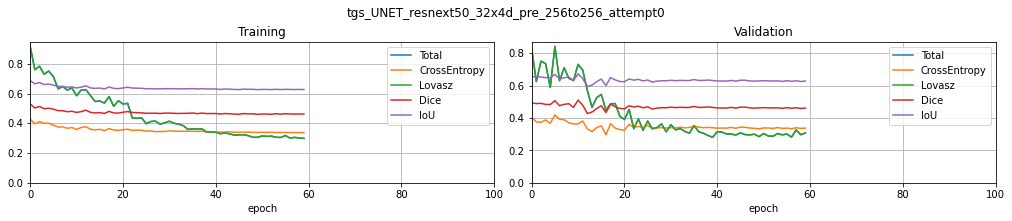

In [33]:
plt.figure(figsize=(14,3))
plt.subplot(121), plt.title('Training')
plt.plot([a.value for a in history['loss/epoch']['train']], label='Total')
plt.plot([a.value for a in history['loss_bce/epoch']['train']], label='CrossEntropy')
plt.plot([a.value for a in history['loss_lov/epoch']['train']], label='Lovasz')
plt.plot([a.value for a in history['loss_dice/epoch']['train']], label='Dice')
plt.plot([a.value for a in history['loss_iou/epoch']['train']], label='IoU')
plt.xlabel('epoch')
plt.xlim(0,args.epochs)
plt.ylim(0)
plt.grid(True)
plt.legend()

plt.subplot(122), plt.title('Validation')
plt.plot([a.value for a in history['loss/epoch']['valid']], label='Total')
plt.plot([a.value for a in history['loss_bce/epoch']['valid']], label='CrossEntropy')
plt.plot([a.value for a in history['loss_lov/epoch']['valid']], label='Lovasz')
plt.plot([a.value for a in history['loss_dice/epoch']['valid']], label='Dice')
plt.plot([a.value for a in history['loss_iou/epoch']['valid']], label='IoU')
plt.xlabel('epoch')
plt.xlim(0,args.epochs)
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.suptitle(args.outname)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"history.{save_opts['format']}"), **save_opts)
plt.show()

## Model inference

Let's look at the model's predictions.


In [36]:
if args.include_eni1:
    patches_images_test = eni_patches_images_test
else:
    # patches_images_test = np.concatenate((eni_patches_images_train, eni_patches_images_test), axis=0)
    patches_images_test = eni_patches_images_test
    
print(patches_images_test.shape)

(3009, 256, 256, 1)


In [37]:
test_transforms  = compose([pre_transform(args.target_shape), tensor_transforms(False)])
final_transforms = compose([pre_transform(pe.dim)])

In [41]:
if not runner.model:
    runner.model = model

In [42]:
# create test dataset
test_dataset = SegmentationDataset(
    patches_images_test, 
    transforms=test_transforms
)

infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

# this get predictions for the whole loader, using the sigmoid activation
predictions = np.vstack(list(map(
    lambda x: x["logits"].sigmoid().cpu().numpy(), 
    runner.predict_loader(loader=infer_loader, resume=f"{args.logdir}/checkpoints/best.pth")
)))

print(predictions.shape)

(3009, 1, 256, 256)


In [43]:
patch_array_shape = u.patch_array_shape(images_test.shape, pe.dim, pe.stride)
patch_array_shape

(17, 177, 256, 256)

In [44]:
result = []
for p in predictions:
    result.append(final_transforms(**{'image':p.transpose(1,2,0)})['image'])
result = np.asarray(result)
result = pe.reconstruct(np.asarray(result).reshape(patch_array_shape))

In [45]:
def binarize(x, th=0.5):
    x = u.normalize_only(x, zero_mean=False)
    x[x>=th] = 1
    x[x<th] = 0
    return x

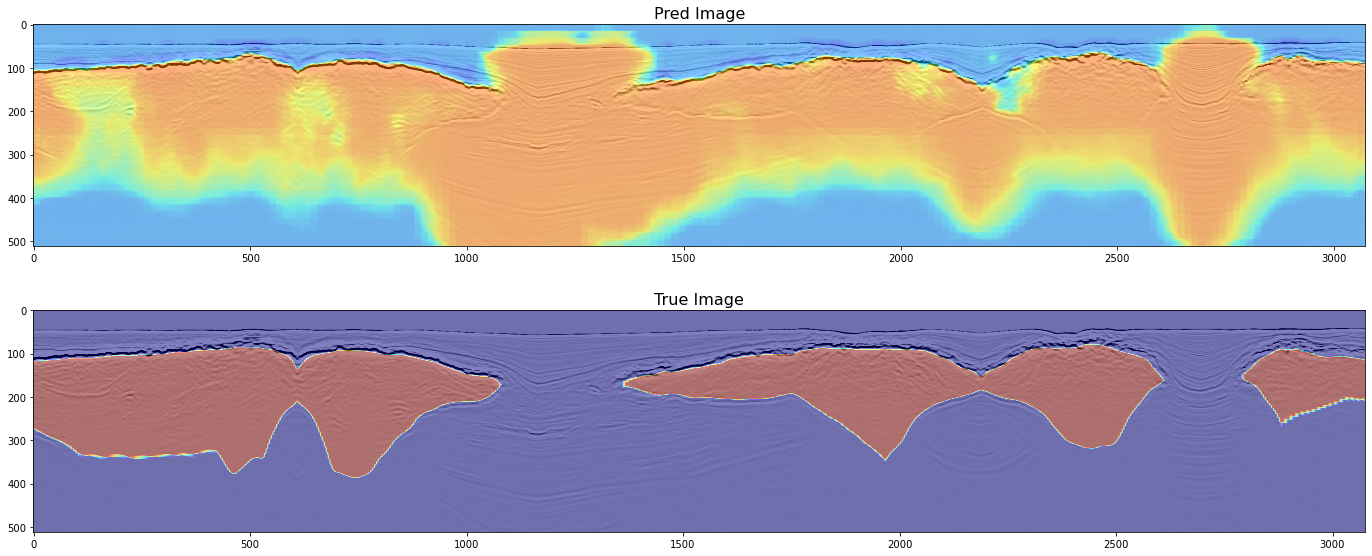

In [46]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.5
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(result, cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', clim=(0,1), alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"test image 2.{save_opts['format']}"), **save_opts)
plt.show()

## test-time augmentations (TTA)

In [47]:
from pytorch_toolbelt.inference import tta

tta_model = tta.TTAWrapper(model, tta.fliplr_image2mask)

tta_runner = SupervisedRunner(
    model=tta_model,
    device=device,
    input_key="image"
)

In [48]:
tta_predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    tta_runner.predict_loader(loader=infer_loader)
)))

print(tta_predictions.shape)

(3009, 1, 256, 256)


In [49]:
tta_result = []
for p in tta_predictions:
    tta_result.append(final_transforms(**{'image':p.transpose(1,2,0)})['image'])
tta_result = np.asarray(tta_result)
tta_result = pe.reconstruct(np.asarray(tta_result).reshape(patch_array_shape))

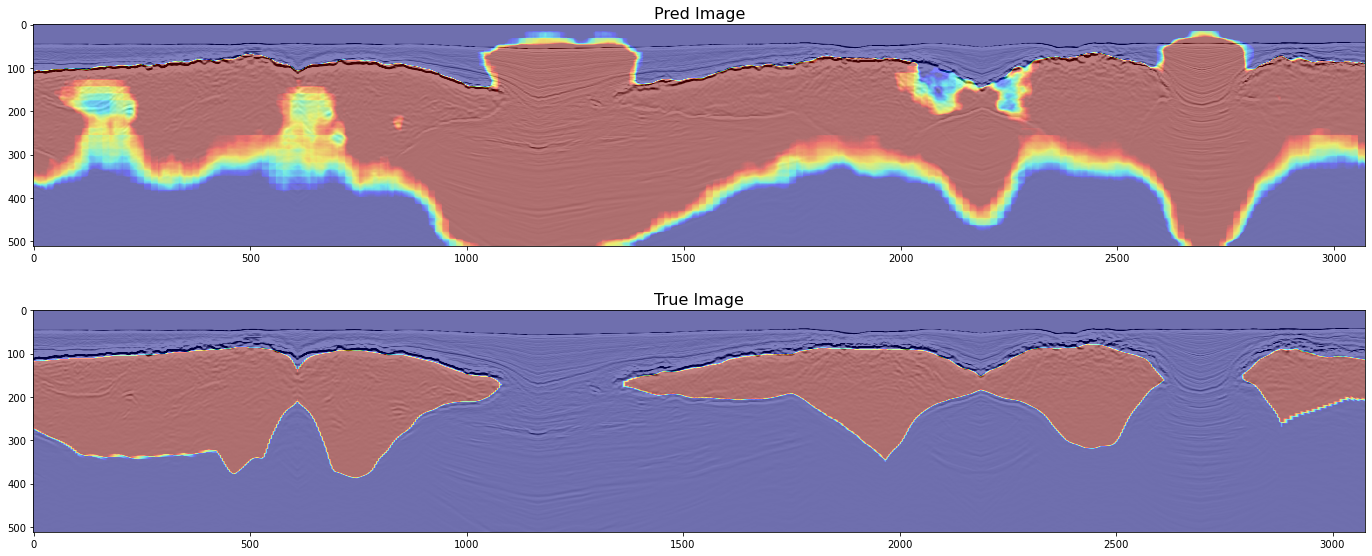

In [51]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.5
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(tta_result, cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', clim=(0,1), alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"test image 2 TTA.{save_opts['format']}"), **save_opts)
plt.show()

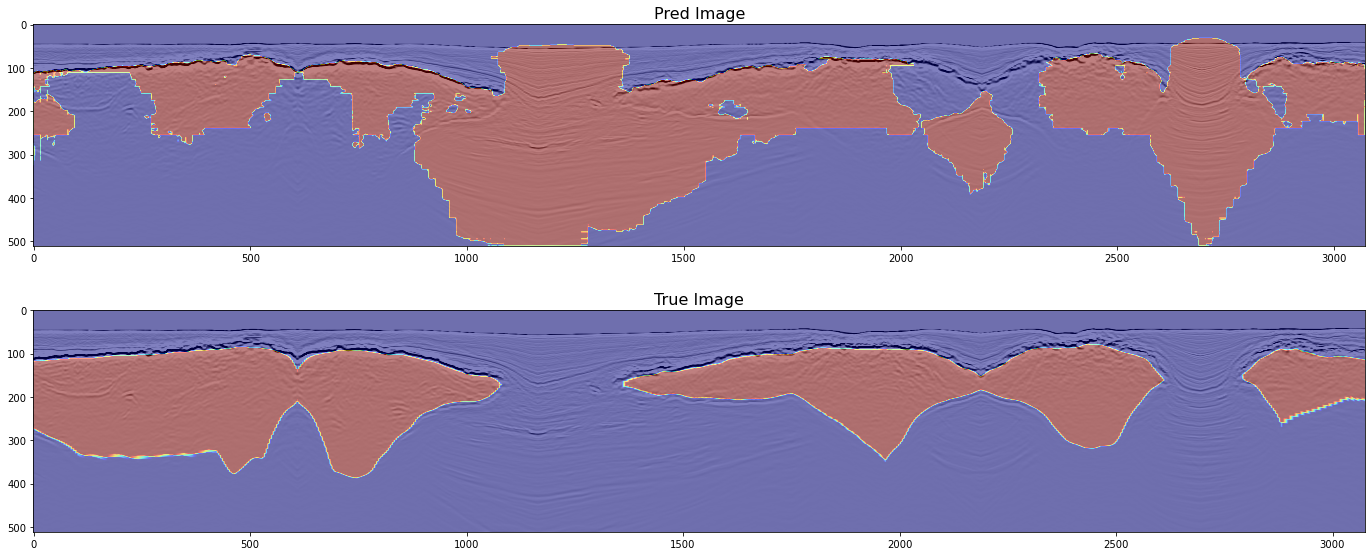

In [54]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.9
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(binarize(tta_result, th), cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"test image 2 TTA binarized %.1f.{save_opts['format']}" % th), **save_opts)
plt.show()